# <center>Исследование надёжности заёмщиков<center>

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### 1. Загрузка и изучение данных 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns',20)
pd.set_option('display.max_rows',20)

In [26]:
data_bank = pd.read_csv('/datasets/data.csv')
display(data_bank.head())
data_bank.info()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [3]:
#просмотрим данные для выявления артефактов
print("---  Кол-во детей в семье  ---")
print(data_bank["children"].value_counts()) 
print("---  Отрицательный и нулевой стаж  ---")
print(data_bank[data_bank["days_employed"] <= 0]["days_employed"].count())
print("---  Незаполенный стаж  ---")
print(data_bank[data_bank["days_employed"].isnull()]["children"].count())
print("---  Отрицательный и нулевой доход  ---")
print(data_bank[data_bank["total_income"] <= 0]["total_income"].count())
print("---  Незаполенный доход  ---")
print(data_bank[data_bank["total_income"].isnull()]["children"].count())
print("---  Незаполенный доход и стаж ---")
no_income = data_bank[data_bank["total_income"].isnull()]
print(no_income[no_income["days_employed"].isnull()]["children"].count())
print("---  Возраст менее 14 лет  ---")
print(data_bank[data_bank["dob_years"] <= 14]["dob_years"].count())
print("---  Возраст более 14 лет по группам  ---")
print(data_bank[data_bank["dob_years"] > 14]["dob_years"].value_counts())
print("---  Образование  ---")
print(data_bank["education"].value_counts()) 
print(data_bank["education_id"].value_counts()) 
print("---  Семейное положение  ---")
print(data_bank["family_status"].value_counts()) 
print(data_bank["family_status_id"].value_counts()) 
print("---  Пол  ---")
print(data_bank["gender"].value_counts()) 
print("---  Тип занятости  ---")
print(data_bank["income_type"].value_counts()) 
print("---  Задолженность  ---")
print(data_bank["debt"].value_counts()) 
print("---  Цель получения кредита  ---")
print(data_bank["purpose"].value_counts()) 
print("---  Отсутствует ли стаж по группам занятости  ---")
print(data_bank[data_bank["days_employed"].isnull()]["income_type"].value_counts())

---  Кол-во детей в семье  ---
 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64
---  Отрицательный и нулевой стаж  ---
15906
---  Незаполенный стаж  ---
2174
---  Отрицательный и нулевой доход  ---
0
---  Незаполенный доход  ---
2174
---  Незаполенный доход и стаж ---
2174
---  Возраст менее 14 лет  ---
101
---  Возраст более 14 лет по группам  ---
35    617
40    609
41    607
34    603
38    598
     ... 
72     33
19     14
73      8
74      6
75      1
Name: dob_years, Length: 57, dtype: int64
---  Образование  ---
среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ

### Вывод

Первым этапом моего проекта является изучение и анализ информации, предоставленной заказчиком. Из общей информации по файлу видно, что перед нами таблица из 21525 записей, состоящая из 12 именованных столбцов. 
Перечень выявленных задач для предобработки данных:

- В столбце "children" (количество детей) содержатся артефакты: 20 детей и (-1). Принято решение удалить.
- В столбцах "days_employed" (общий трудовой стаж в днях) и "total_income" (ежемесячный доход) содержатся пропуски. Это пропуски в количественных переменных. При этом легко подсчитать, что отсутствует около 9% информации, которую не хотелось бы удалять. Сразу бросается в глаза, что в этих столбцах содержится одинаковое количество ненулевых строк. Сделав ряд срезов, я выявила, что 2174 строки содержат пропущенные значения одновременно в "days_employed" и "total_income". 
 Также в "days_employed" значения преимущественно имеют отрицательное значение. Этот факт я связываю с человеческим фактором и неправильным форматом ввода данных. Принято решение применить к данным столбца метод модуля abs().
 Отсутствие информации считаю неслучайным, но так как она не влияет на результат поставленной задачи принято решение в столбце "days_employed" пустые значения заменить нулями, а в "total_income" вместо пустых значений внести медиану по типу занятости.
- В столбцае "dob_years" найдена 101 запись со значением 0. Принято решение удалить.
- В столбце "education" необходимо поработать с дубликатами.
- В столбцах "family_status" и "family_status_id" все нормально.
- В "gender" одна запись без указания пола. Принято решение удалить.
- В "income_type" "debt"все благополучно.
- В "purpose" необходимо произвести лемматизацию.



### 2. Предобработка данных

### Обработка пропусков

In [4]:
#Удалим записи с некорректным количеством детей у заемщиков
data_bank = data_bank[(data_bank["children"] != (-1))&(data_bank["children"] != 20)] 
print(data_bank.shape)
#Удалим записи с некорректным возрастом заемщиков
data_bank = data_bank[(data_bank["dob_years"] >= 14)]
print(data_bank.shape)
#Удалим запись с неопределенным полом заемщика.
data_bank = data_bank[(data_bank["gender"] == "F")|(data_bank["gender"] == "M")]
print(data_bank.shape)
#Исправляем отрицательный "стаж".
data_bank["days_employed"] = data_bank["days_employed"].abs()
#Заполняем пустоты в "стаже" нулями.
data_bank["days_employed"] = data_bank["days_employed"].fillna(0)
#Сделаем проверку.
print(data_bank[data_bank["days_employed"] < 0]["days_employed"].count())
print(data_bank[data_bank["days_employed"].isnull()]["children"].count())

#Функция расчитывает медиану дохода для конкретной категории занятости и
#записывает полученное значение в пустые поля данной группы.

def fill_total (data, it):
    med = data[(data["income_type" ] == it)&(~data["total_income"].isnull())]["total_income"].median()
    data.loc[data["income_type"] == it, 'total_income'] = data.loc[data["income_type" ] == it, 'total_income'].fillna(med)
    return data

data_bank = fill_total(data_bank, "госслужащий")
data_bank = fill_total(data_bank, "сотрудник")
data_bank = fill_total(data_bank, "компаньон")
data_bank = fill_total(data_bank, "пенсионер")
data_bank = fill_total(data_bank, "в декрете")
data_bank = fill_total(data_bank, "студент")
data_bank = fill_total(data_bank, "предприниматель")
data_bank = fill_total(data_bank, "безработный")

#Проверка
print("---  Отрицательный и нулевой доход  ---")
print(data_bank[data_bank["total_income"] <= 0]["total_income"].count())
print("---  Незаполенный доход  ---")
print(data_bank[data_bank["total_income"].isnull()]["children"].count())


(21402, 12)
(21302, 12)
(21301, 12)
0
0
---  Отрицательный и нулевой доход  ---
0
---  Незаполенный доход  ---
0


### Вывод

Некоторые строки были удалены, так как их количество мало и нет возможности восстановить отсутствующие данные.
Для заполения неизвестных значений "дохода" была написана функция, вычисляющая среднее значение дохода для данной категории заемщиков.

### Замена типа данных

In [5]:
data_bank["days_employed"] = data_bank["days_employed"].astype("int")
print(data_bank.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21301 entries, 0 to 21524
Data columns (total 12 columns):
children            21301 non-null int64
days_employed       21301 non-null int64
dob_years           21301 non-null int64
education           21301 non-null object
education_id        21301 non-null int64
family_status       21301 non-null object
family_status_id    21301 non-null int64
gender              21301 non-null object
income_type         21301 non-null object
debt                21301 non-null int64
total_income        21301 non-null float64
purpose             21301 non-null object
dtypes: float64(1), int64(6), object(5)
memory usage: 2.1+ MB
None


### Вывод

В столбце "days_employed"(стаж в днях), имеющим первоначально вещественный тип, была произведена замена на целый тип с применением метода astype(). Это сделано для упрощения восприятия информации о стаже в днях. В данном случае точность информации не влияет на результат поставленной задачи.

### Обработка дубликатов

In [28]:
data_bank["education"] =data_bank["education"].str.lower()
print(data_bank["education"].value_counts())
#Проверим наличие дубликатов и удалим, если имеются.
dup_count = data_bank.duplicated().sum()
print("Кол-во удаляемых дубликатов:", dup_count)
data_bank = data_bank.drop_duplicates().reset_index(drop = True)

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64
Кол-во удаляемых дубликатов: 71


### Вывод

Для обнаружения дубликатов в столбце "education"(образование) был использован метод value_counts(). В результате было выявлено, что названия уровня образования набраны в разном регистре. Для исправления ситуации и удаления дубликатов был использован метод str.lower(). Возможная причина возникновения дубликатов - человеческий фактор. Методом data_bank.duplicated() была найдена 71 строка полностью, совподающая с другими. Было произведено удаление дубликатов методом drop_duplicates().

### Лемматизация

In [7]:
from pymystem3 import Mystem
m = Mystem()

#Функция лемматизации строки
def lemma_row (row):
    lemmas = m.lemmatize(row)
   
    if "ремонт" in  lemmas:
        return "ремонт жилья"
    elif ("недвижимость" in  lemmas)|("жилье" in  lemmas):
        return "недвижимость"
    elif "свадьба" in  lemmas:
        return "свадьба"
    elif "автомобиль" in  lemmas:
        return "автомобиль"
    elif "образование" in  lemmas:
        return "образование"
    else:
        return "неизвестная категория"
    
data_bank["purpose_lem"] = data_bank["purpose"].apply(lemma_row )
print(data_bank["purpose_lem"].value_counts())

недвижимость    10125
автомобиль       4267
образование      3979
свадьба          2323
ремонт жилья      607
Name: purpose_lem, dtype: int64


### Вывод

Все цели в представленной заказчиком таблице были обьединены в пять групп с помощью процесса лемматизации. В данном пункте лемматизация совмещена с категоризацией и затем данные сохранены в дополнительный столбец "purpose_lem".

### Категоризация данных

In [8]:
#Категоризация по наличию детей у заемщика: 1 - имеет, 0 -не имеет.
def have_children (cnt):
    if cnt > 0:
        return 1
    else: 
        return 0
data_bank["have_children"] = data_bank["children"].apply(have_children)

#Категоризация по уровню дохода
min_income = data_bank["total_income"].min()
max_income = data_bank["total_income"].max()
med_income = data_bank["total_income"].median()
#avg_income = data_bank["total_income"].sum() / data_bank["total_income"].count()

# Функция категоризации на 4 группы с использанием медианы значения дохода
# 0 - доход ниже половины медианы
# 1 - доход от половины медианы и до целой медианы
# 2 - доход от медианы до 1,5 медианы
# 3 - доход выше 1,5 медианы
def income_category_med(income):
    global med_income
    if income < med_income / 2:
        return 0
    elif income < med_income:
        return 1
    elif income < med_income + med_income / 2:
        return 2
    else:
        return 3

data_bank["income_group_med"] = data_bank["total_income"].apply(income_category_med)
print(data_bank["income_group_med"].value_counts())




1    8134
2    7334
3    4271
0    1562
Name: income_group_med, dtype: int64


### Вывод

Задача категоризации заемщиков по количеству детей очень проста, т.к. в задании необходимо определить влияние наличия детей на кредитную историю, т.е. необходимо разделить заемщиков на две группы - есть дети или нет.
Для категоризации заемщиков по уровню дохода можно использовать медианное значение дохода в качестве вспомогательной величины. Предлагается разделить всех заемщиков на 4 группы. Как и следовало ожидать, в группы с наименьшим и наибольшим доходом попало 
меньше людей, чем в средние две группы. Но при этом группы 0 и 3 достаточно велики, чтобы можно было сделать по ним выводы.

### 3. Исследование обработанных данных

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [9]:
pivot_child = data_bank.pivot_table(index=['have_children'], columns=['debt'], values='gender', aggfunc='count')
pivot_child.set_axis(["Вернувшие","Невернувшие"],axis = "columns", inplace =  True)
pivot_child.set_axis(["не имеют детей","имеют детей"],axis = "index",inplace =  True)
pivot_child['Всего'] = pivot_child["Вернувшие"] + pivot_child["Невернувшие"]
pivot_child['Доля должников,%'] = pivot_child["Невернувшие"]/pivot_child['Всего']*100
print("---Зависимость между наличием детей и возвратом кредита в срок---")
print(pivot_child)

---Зависимость между наличием детей и возвратом кредита в срок---
                Вернувшие  Невернувшие  Всего  Доля должников,%
не имеют детей      13021         1058  14079          7.514738
имеют детей          6556          666   7222          9.221822


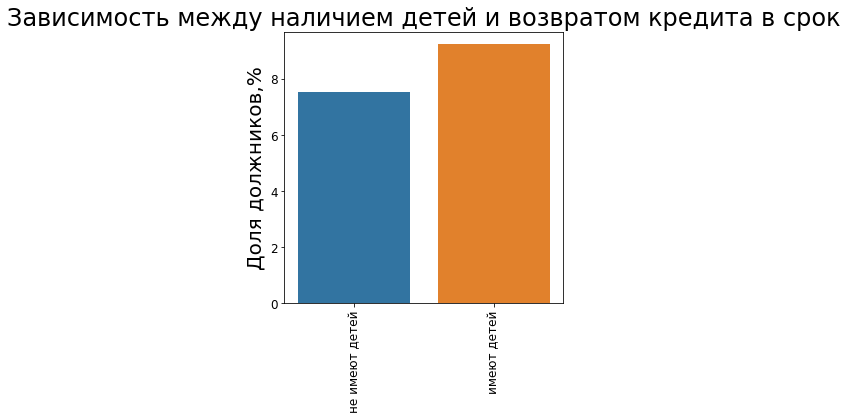

In [31]:
plt.figure(figsize=(5, 5))
sns.barplot(pivot_child.index, pivot_child['Доля должников,%'])
plt.title("Зависимость между наличием детей и возвратом кредита в срок", fontsize=24)

plt.ylabel('Доля должников,%', fontsize=20)

plt.xticks(rotation=90,fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Вывод

Мы получили близкие значения. Можно сказать, что наличие детей незначительно влияет на возврат кредита. Причем вероятность задолжности заемщиков с детьми повышается на 1,7%. 

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [10]:
pivot_family_status = data_bank.pivot_table(index=["family_status_id"], columns=['debt'], values='gender', aggfunc='count')
pivot_family_status.set_axis(["Вернувшие","Невернувшие"],axis = "columns", inplace =  True)
pivot_family_status.set_axis(["женатые/замужние","гражданский брак","вдовы/вдовцы","в разводе","неженатые/незамужние"]
                             ,axis = "index", inplace =  True)
pivot_family_status['Всего'] = pivot_family_status["Вернувшие"] + pivot_family_status["Невернувшие"]
pivot_family_status["Доля должников,%"] = pivot_family_status["Невернувшие"]/pivot_family_status['Всего']*100
print("---Зависимость между семейным положением и возвратом кредита в срок---")
print(pivot_family_status)

---Зависимость между семейным положением и возвратом кредита в срок---
                      Вернувшие  Невернувшие  Всего  Доля должников,%
женатые/замужние          11331          923  12254          7.532234
гражданский брак           3755          383   4138          9.255679
вдовы/вдовцы                885           62    947          6.546990
в разводе                  1095           84   1179          7.124682
неженатые/незамужние       2511          272   2783          9.773626


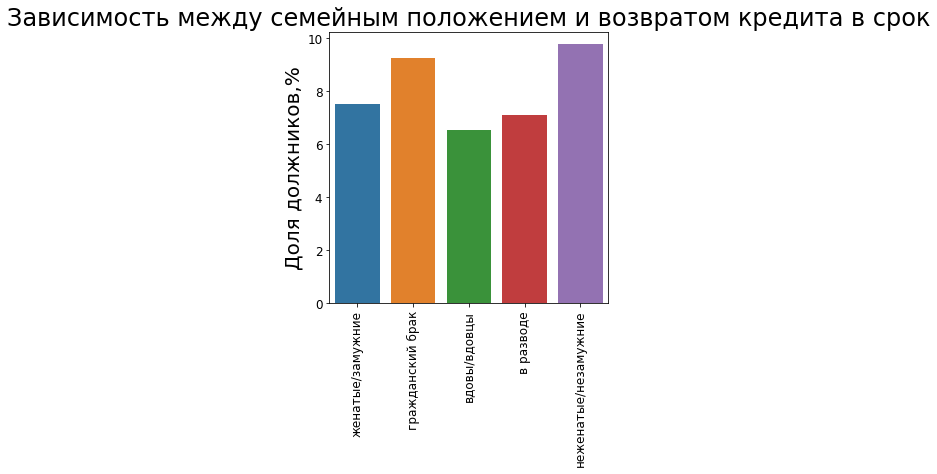

In [32]:
plt.figure(figsize=(5, 5))
sns.barplot(pivot_family_status.index, pivot_family_status['Доля должников,%'])
plt.title("Зависимость между семейным положением и возвратом кредита в срок", fontsize=24)

plt.ylabel('Доля должников,%', fontsize=20)

plt.xticks(rotation=90,fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Вывод
Есть зависимость между семейным положением и возвратом кредита в срок, но разрыв по данным небольшой. Самые дисциплинированные вдовы и вдовцы: 6.5% невозврата. А самый больший процент по невозврату кредитов у неженатых или незамужних заемщиков: 9.8%.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [11]:
pivot_income = data_bank.pivot_table(index=["income_group_med"], columns=['debt'], values='gender', aggfunc='count')
pivot_income.set_axis(["Вернувшие","Невернувшие"],axis = "columns", inplace =  True)
pivot_income.set_axis(["минимальный доход","доход ниже среднего","доход выше среднего","высокий доход"],axis = "index", inplace =  True)
pivot_income['Всего'] = pivot_income["Вернувшие"] + pivot_income["Невернувшие"]
pivot_income["Доля должников,%"] = pivot_income["Невернувшие"]/pivot_income['Всего']*100
print("---Зависимость между уровнем дохода и возвратом кредита в срок---")
print(pivot_income)


---Зависимость между уровнем дохода и возвратом кредита в срок---
                     Вернувшие  Невернувшие  Всего  Доля должников,%
минимальный доход         1453          109   1562          6.978233
доход ниже среднего       7438          696   8134          8.556676
доход выше среднего       6717          617   7334          8.412872
высокий доход             3969          302   4271          7.070944


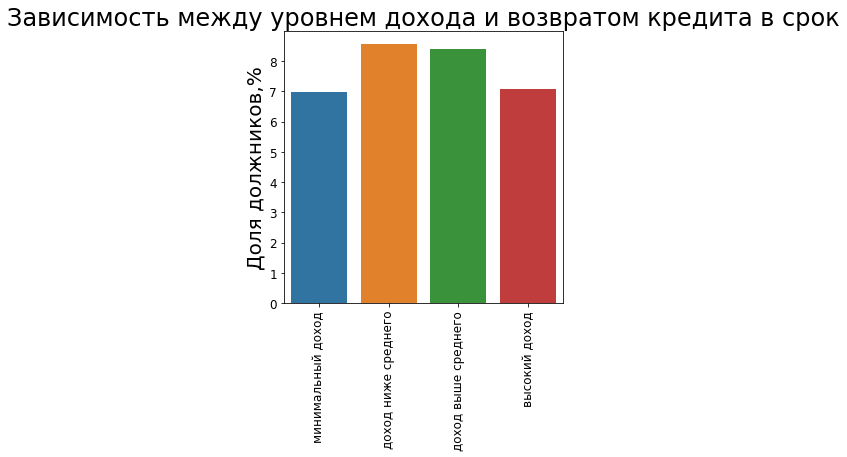

In [25]:
plt.figure(figsize=(5, 5))
sns.barplot(pivot_income.index, pivot_income['Доля должников,%'])
plt.title("Зависимость между уровнем дохода и возвратом кредита в срок", fontsize=24)

plt.ylabel('Доля должников,%', fontsize=20)

plt.xticks(rotation=90,fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Вывод

Очевидно, что уровень дохода влияет на кредитную историю. Самыми дисциплинированными являются заемщики с минимальным и максимальным доходом, а люди со средним доходом попадают в должники чаще.

- Как разные цели кредита влияют на его возврат в срок?

In [13]:
pivot_purp = data_bank.pivot_table(index=["purpose_lem"], columns=['debt'], values='gender', aggfunc='count')
pivot_purp.set_axis(["Вернувшие","Невернувшие"],axis = "columns", inplace =  True)

pivot_purp['Всего'] = pivot_purp["Вернувшие"] + pivot_purp["Невернувшие"]
pivot_purp["Доля должников,%"] = pivot_purp["Невернувшие"]/pivot_purp['Всего']*100
print("---Зависимость между целями кредита и возвратом кредита в срок---")
print(pivot_purp)

---Зависимость между целями кредита и возвратом кредита в срок---
              Вернувшие  Невернувшие  Всего  Доля должников,%
purpose_lem                                                  
автомобиль         3870          397   4267          9.303961
недвижимость       9383          742  10125          7.328395
образование        3610          369   3979          9.273687
ремонт жилья        572           35    607          5.766063
свадьба            2142          181   2323          7.791649


### Вывод

Видим, что самые дисциплинированные заемщики, взявшие кредит на ремон жилья: 5.8% невозврата. А самый большой процент невозврата кредитов на автомобили и образование.

### 4. Общий вывод

Итак, подтвердилась гипотеза о существовании зависимости между семейным положением, количеством детей, целями кредита, уровнем дохода и вероятностью возникновения просрочки. Самыми благонадежными оказались вдовы(вдовцы), не имеющие детей, с небольшим уровнем дохода, взявшие кредит на ремонт жилья. Наибольший риск просрочки возникает у заемщиков, не состоящих в браке, со средним уровнем дохода, взявшие кредит на покупку автомобиля или обучение.
В целом, вероятность попадания заемщика в должники колеблется от 6% до 10%. Эту информацию необходимо учитывать банкам при разработке своей кредитной политики. Например, процент по автокредиту целесообразно сделать выше, чем по кредиту на покупку недвижимости.